# TalkingData AdTracking Fraud Detection Challenge

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, **you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad.** To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

### Data Manipulating

In [1]:
import pandas as pd

df = pd.read_csv('train_all.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 76 columns):
record              1500000 non-null int64
channelIp10s        1500000 non-null int64
channelIp3s         1500000 non-null int64
channelApp10s       1500000 non-null int64
channelApp3s        1500000 non-null int64
channelDevice10s    1500000 non-null int64
channelDevice3s     1500000 non-null int64
channelOs10s        1500000 non-null int64
channelOs3s         1500000 non-null int64
osIp10s             1500000 non-null int64
osIp3s              1500000 non-null int64
osApp10s            1500000 non-null int64
osApp3s             1500000 non-null int64
osDevice10s         1500000 non-null int64
osDevice3s          1500000 non-null int64
osChannel10s        1500000 non-null int64
osChannel3s         1500000 non-null int64
deviceIp1s          1500000 non-null int64
deviceApp1s         1500000 non-null int64
deviceOs1s          1500000 non-null int64
deviceChannel1s     1500000

In [92]:
#get y
y = df.is_attributed.values

#get X and drop y 
X = df.drop(columns=['record', 'click_time', 'is_attributed', 'ip'])#, 'channelAttrib', 'hourAttrib','osAttrib', 'deviceAttrib', 'appAttrib', 'ipAttrib'])
X.hour = X.hour.astype('category')
X.channel = X.channel.astype('category')
X.os = X.os.astype('category')
X.device = X.device.astype('category')
X.app = X.app.astype('category')

print(y[:10])
print(X.iloc[:5,21:40])

[0 0 0 0 0 0 0 0 0 0]
   appIp3s  appDevice10s  appDevice3s  appOs10s  appOs3s  appChannel10s  \
0        1             1            1         1        1              1   
1        2             1            1         2        2              2   
2        1             1            1         1        1              1   
3        2             2            2         2        2              2   
4        1             1            1         1        1              1   

   appChannel3s  ipApp10s  ipApp3s  ipDevice10s  ipDevice3s  ipOs10s  ipOs3s  \
0             1         1        1            1           1        1       1   
1             2         1        1            1           1        1       1   
2             1         1        1            1           1        1       1   
3             2         1        1            1           1        1       1   
4             1         1        1            1           1        1       1   

   ipChannel10s  ipChannel3s hour  hourAttrib 

In [93]:
X = X.drop(columns=['hour', 'channel', 'os', 'device', 'app'])

### Downsampling

In [94]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000000)

goods = (y_train==1)

X_train_goods = X_train[goods]
y_train_goods = y_train[goods]

X_train_bads = X_train[~goods]
y_train_bads = y_train[~goods]

index = np.random.choice(range(len(y_train_bads)), len(y_train_goods)*3)

print(len(y_train_goods), len(y_train_bads), len(index))

X_train = pd.concat( [X_train_goods,X_train_bads.iloc[index,:]], axis=0)
y_train = np.hstack([y_train_goods,y_train_bads[index]])

print(len(y_train))
X_train.info()

/Users/simba/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


3473 996527 10419
13892
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13892 entries, 514667 to 1019035
Data columns (total 67 columns):
channelIp10s        13892 non-null int64
channelIp3s         13892 non-null int64
channelApp10s       13892 non-null int64
channelApp3s        13892 non-null int64
channelDevice10s    13892 non-null int64
channelDevice3s     13892 non-null int64
channelOs10s        13892 non-null int64
channelOs3s         13892 non-null int64
osIp10s             13892 non-null int64
osIp3s              13892 non-null int64
osApp10s            13892 non-null int64
osApp3s             13892 non-null int64
osDevice10s         13892 non-null int64
osDevice3s          13892 non-null int64
osChannel10s        13892 non-null int64
osChannel3s         13892 non-null int64
deviceIp1s          13892 non-null int64
deviceApp1s         13892 non-null int64
deviceOs1s          13892 non-null int64
deviceChannel1s     13892 non-null int64
appIp10s            13892 non-null int64

### Gaussian Mixture Model

In [95]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

from sklearn.model_selection import train_test_split

lowest_bic = np.infty
bic = []
score = []
n_components_range = range(1, 15)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    score_tmp = []
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X_train)
        bic.append(gmm.bic(X_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
        score_tmp.append(gmm.score(X_train))
        print(cv_type, n_components)
    score.append(score_tmp)

spherical 1
spherical 2
spherical 3
spherical 4
spherical 5
spherical 6
spherical 7
spherical 8
spherical 9
spherical 10
spherical 11
spherical 12
spherical 13
spherical 14
tied 1
tied 2
tied 3
tied 4
tied 5
tied 6
tied 7
tied 8
tied 9
tied 10
tied 11
tied 12
tied 13
tied 14
diag 1
diag 2
diag 3
diag 4
diag 5
diag 6
diag 7
diag 8
diag 9
diag 10
diag 11
diag 12
diag 13
diag 14
full 1
full 2
full 3
full 4
full 5
full 6
full 7
full 8
full 9
full 10
full 11
full 12
full 13
full 14


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=9, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


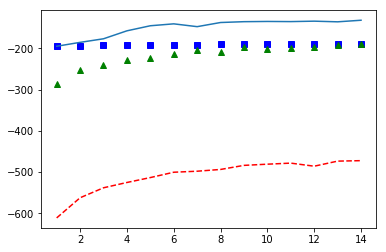

In [97]:
print(best_gmm)

import matplotlib.pyplot as plot

plt.plot(range(1,15), score[0], 'r--', range(1,15), score[1], 'bs', range(1,15), score[2], 'g^', range(1,15), score[3])
plt.show()


In [143]:
from sklearn.metrics import confusion_matrix

clf = mixture.GaussianMixture(n_components=9, covariance_type='full')
clf.fit(X_train)

y_pred = clf.predict(X_train)
print(confusion_matrix(y_train, y_pred))

c_mat = np.array(confusion_matrix(y_train, y_pred))

y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

c_mat[1] /  (c_mat[1] + c_mat[0])

[[  80  363  114 1037 1137  157  308 3439 3784]
 [1268  616 1033   15   73   27   55  273  113]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]]
[[  3427  16286   4698  48231  55950   7422  15580 163552 183107]
 [   573    297    584     11     34      8     50    126     64]
 [     0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0   

array([0.94065282, 0.62921348, 0.90061029, 0.01425856, 0.06033058,
       0.14673913, 0.15151515, 0.07354526, 0.02899666])

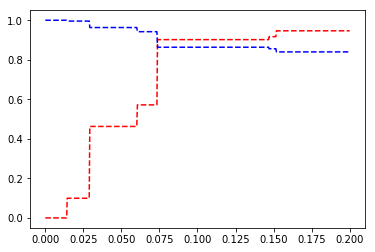

In [144]:
I = np.linspace(0,0.2,500)
Specificity = []
Sensitivity = []
for i in I:
    cc = c_mat[1] /  (c_mat[1]+c_mat[0]) > i
    cc_pred_positive = c_mat.T[cc].sum(axis=0)
    cc_pred_negative = c_mat.T[~cc].sum(axis=0)

    precision = cc_pred_positive[1] / cc_pred_positive.sum()
    specificity = 1 - cc_pred_positive[0] / (cc_pred_positive[0]+cc_pred_negative[0])
    sensitivity = cc_pred_positive[1] / (cc_pred_positive[1]+cc_pred_negative[1]) #Recall

    Specificity.append(specificity)
    Sensitivity.append(sensitivity)
    
plt.plot(I, Specificity, 'r--', I, Sensitivity, 'b--')
plt.show()

### Plot GMM

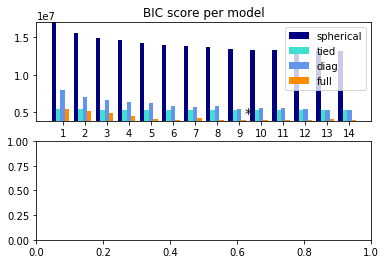

In [100]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)

plt.show()

In [ ]:
Y_ = clf.predict(X_test)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_test[Y_ == i, 0], X_test[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)

### ROC Curve and AUC

In [145]:
# Only select the clusters with higher 
cc = c_mat[1] /  (c_mat[1]+c_mat[0]) > 0.1

y_pred_prob = clf.predict_proba(X_test)

y_pred_prob_positive = y_pred_prob.T[cc].sum(axis=0)
y_pred_prob_negative = y_pred_prob.T[~cc].sum(axis=0)

y_pred_prob_positive

array([2.32504143e-034, 2.11828083e-026, 1.95237346e-023, ...,
       1.23685060e-018, 1.15930300e-121, 1.58705068e-014])

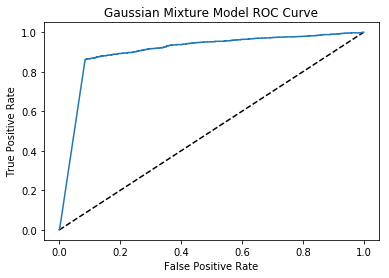

AUC: 0.9034080572655374


In [146]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob_positive)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Gaussian Mixture Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Mixture Model ROC Curve')
plt.show()

print('AUC: {}'.format(roc_auc_score(y_test, y_pred_prob_positive)))

In [147]:
#y_pred = y_pred
#c_mat = confusion_matrix(y_test, y_pred)
print(c_mat)
cc = c_mat[1] /  (c_mat[1]+c_mat[0]) > 0.1
print(cc)
c_mat_test = confusion_matrix(y_test, y_pred)
cc_pred_positive = c_mat_test.T[cc].sum(axis=0)
cc_pred_negative = c_mat_test.T[~cc].sum(axis=0)
c_mat2D = np.hstack([cc_pred_negative[:2].reshape(-1,1),cc_pred_positive[:2].reshape(-1,1)])

[[  80  363  114 1037 1137  157  308 3439 3784]
 [1268  616 1033   15   73   27   55  273  113]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0]]
[ True  True  True False False  True  True False False]


In [148]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print(c_mat2D)

#fdr score
order = np.argsort(-y_pred_prob_positive)
fdr_arr = np.cumsum(y_test[order])/np.sum(y_test)
fdr_percent = np.arange(1,len(y_test)+1).astype(float)/len(y_test)

fdr_rate = 0.1
fdr_arr = np.vstack([fdr_percent, fdr_arr]).T
fdr_arr = fdr_arr[fdr_percent < fdr_rate,:]
fdr_arr = fdr_arr[np.argsort(-fdr_arr[:,0])]
fdr = fdr_arr[0,1]

auc = roc_auc_score(y_test, y_pred_prob_positive)
specificity = 1 - c_mat2D[0][1] / (c_mat2D[0][0]+c_mat2D[0][1])
sensitivity = c_mat2D[1][1] / (c_mat2D[1][0]+c_mat2D[1][1]) #Recall
precision = c_mat2D[1][1] / (c_mat2D[0][1]+c_mat2D[1][1]) #Recall
print(auc, fdr, sensitivity, specificity, precision)

[[450840  47413]
 [   235   1512]]
0.9034080572655374 0.8654836863194046 0.8654836863194046 0.9048415162578047 0.030904445579969343
